In [1]:
# ========================================
# CELL 1: INSTALL & IMPORT
# ========================================

# !pip install -q transformers==4.36.0 peft==0.7.1 datasets==2.16.1 accelerate==0.25.0 sentencepiece bitsandbytes sacrebleu rouge-score

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    T5ForConditionalGeneration, 
    T5Tokenizer,
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments, 
    Trainer,
    DataCollatorForSeq2Seq,
    DataCollatorForLanguageModeling
)
from transformers.modeling_outputs import BaseModelOutput, CausalLMOutputWithCrossAttentions
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from datasets import Dataset, load_from_disk
import os
import json
import math
import numpy as np
import warnings
import gc
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
torch.cuda.empty_cache()

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"✅ Compute Capability: {torch.cuda.get_device_capability(0)}")

2025-11-25 10:38:23.307729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764067103.533194      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764067103.597549      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ PyTorch: 2.6.0+cu124
✅ CUDA Available: True
✅ GPU: Tesla P100-PCIE-16GB
✅ VRAM: 17.06 GB
✅ Compute Capability: (6, 0)


In [2]:
# ========================================
# CELL 2: GLOBAL CONFIGURATION
# ========================================

# ========================================
# CELL 2: GLOBAL CONFIGURATION (UPDATED)
# ========================================

class Config:
    # ✅ THÊM TEST MODE - Bật để test nhanh
    TEST_MODE = True  # ← SET TRUE ĐỂ TEST
    
    # Paths
    DATA_DIR = "/kaggle/input/processed-data"
    OUTPUT_DIR = "/kaggle/working/models"
    
    # ✅ Training params - Dynamic based on TEST_MODE
    if TEST_MODE:
        print("⚡ TEST MODE ENABLED - Fast Training")
        NUM_EPOCHS = 3  # Chỉ 1 epoch
        MAX_INPUT_LENGTH = 128  # Giảm từ 256
        MAX_TARGET_LENGTH = 64   # Giảm từ 128
        TRAIN_SAMPLES = 1000     # Chỉ lấy 1k samples
        VAL_SAMPLES = 200
        TEST_SAMPLES = 100
        EVAL_STEPS = 50          # Eval sớm hơn
        SAVE_STEPS = 50
        LOGGING_STEPS = 10
    else:
        print("🔥 FULL TRAINING MODE")
        NUM_EPOCHS = 3
        MAX_INPUT_LENGTH = 256
        MAX_TARGET_LENGTH = 128
        TRAIN_SAMPLES = None     # Dùng hết data
        VAL_SAMPLES = None
        TEST_SAMPLES = None
        EVAL_STEPS = 200
        SAVE_STEPS = 200
        LOGGING_STEPS = 50
    
    # Model configs
    MODELS = {
        "vit5-base": {
            "name": "VietAI/vit5-base",
            "type": "t5-advanced",
            "batch_size": 32 if TEST_MODE else 16,  # ✅ Tăng batch trong test
            "learning_rate": 2e-4 if TEST_MODE else 1e-4,  # ✅ LR cao hơn
            "gradient_accumulation": 1 if TEST_MODE else 2,  # ✅ Bỏ accumulation
            "lora_r": 16 if TEST_MODE else 32,  # ✅ LoRA nhỏ hơn
            "lora_alpha": 32 if TEST_MODE else 64,
        },
        
        "gpt-neo-vi": {
            "name": "VietAI/gpt-neo-1.3B-vietnamese-news",
            "type": "gpt",
            "batch_size": 8 if TEST_MODE else 4,
            "learning_rate": 1e-4 if TEST_MODE else 5e-5,
            "gradient_accumulation": 2 if TEST_MODE else 8,
            "lora_r": 8 if TEST_MODE else 16,
            "lora_alpha": 16 if TEST_MODE else 32,
        },
        
        "mt5-base": {
            "name": "google/mt5-base",
            "type": "mt5-simple",
            "batch_size": 24 if TEST_MODE else 12,
            "learning_rate": 1e-4 if TEST_MODE else 5e-5,
            "gradient_accumulation": 1 if TEST_MODE else 3,
            "lora_r": 16 if TEST_MODE else 32,
            "lora_alpha": 32 if TEST_MODE else 64,
        }
    }

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("="*80)
print("📋 COMPARISON: 3 DIFFERENT MODELS")
print("="*80)
for name, cfg in config.MODELS.items():
    print(f"\n{name}:")
    print(f"  Model: {cfg['name']}")
    print(f"  Type: {cfg['type']}")
    print(f"  Batch: {cfg['batch_size']} × {cfg['gradient_accumulation']} = {cfg['batch_size'] * cfg['gradient_accumulation']}")
print("="*80)

⚡ TEST MODE ENABLED - Fast Training
📋 COMPARISON: 3 DIFFERENT MODELS

vit5-base:
  Model: VietAI/vit5-base
  Type: t5-advanced
  Batch: 32 × 1 = 32

gpt-neo-vi:
  Model: VietAI/gpt-neo-1.3B-vietnamese-news
  Type: gpt
  Batch: 8 × 2 = 16

mt5-base:
  Model: google/mt5-base
  Type: mt5-simple
  Batch: 24 × 1 = 24


In [3]:
# ========================================
# CELL 3: LOAD DATA (CHUNG CHO CẢ 3 MODELS)
# ========================================

def load_data():
    print("="*70)
    print("📂 LOADING DATA")
    print("="*70)
    
    train_df = pd.read_csv(f"{config.DATA_DIR}/train.csv")
    val_df = pd.read_csv(f"{config.DATA_DIR}/val.csv")
    test_df = pd.read_csv(f"{config.DATA_DIR}/test.csv")
    
    # Clean
    for df in [train_df, val_df, test_df]:
        df.dropna(subset=['input_text', 'target_text'], inplace=True)
        df['input_text'] = df['input_text'].str.strip()
        df['target_text'] = df['target_text'].str.strip()
    
    # ✅ SAMPLE DATA IN TEST MODE
    if config.TEST_MODE:
        train_df = train_df.head(config.TRAIN_SAMPLES)
        val_df = val_df.head(config.VAL_SAMPLES)
        test_df = test_df.head(config.TEST_SAMPLES)
        print("⚡ Using sampled data for fast testing")
    
    print(f"✅ Train: {len(train_df):,}")
    print(f"✅ Val: {len(val_df):,}")
    print(f"✅ Test: {len(test_df):,}")
    
    return train_df, val_df, test_df

train_df, val_df, test_df = load_data()

📂 LOADING DATA
⚡ Using sampled data for fast testing
✅ Train: 1,000
✅ Val: 200
✅ Test: 100


In [4]:
# ========================================
# CELL 4: CUSTOM ADVANCED ARCHITECTURE (CODE CŨ)
# ========================================

import math

class CustomMultiHeadAttention(nn.Module):
    """Multi-Head Attention với Scaled Dot-Product"""
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        assert self.head_dim * num_heads == hidden_size
        
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_length, _ = hidden_states.size()
        
        Q = self.query(hidden_states)
        K = self.key(hidden_states)
        V = self.value(hidden_states)
        
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask == 0, -1e4)
        
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.hidden_size)
        output = self.out(context)
        
        return output, attn_weights


class BiLSTMLayer(nn.Module):
    """Bidirectional LSTM để capture context hai chiều"""
    def __init__(self, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size // 2,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, hidden_states):
        lstm_out, _ = self.lstm(hidden_states)
        output = self.layer_norm(hidden_states + self.dropout(lstm_out))
        return output


class RNNLayer(nn.Module):
    """Simple RNN layer"""
    def __init__(self, hidden_size, num_layers=1, dropout=0.1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, hidden_states):
        rnn_out, _ = self.rnn(hidden_states)
        output = self.layer_norm(hidden_states + self.dropout(rnn_out))
        return output


class FeedForwardNetwork(nn.Module):
    """Position-wise Feed Forward Network"""
    def __init__(self, hidden_size, ff_size=None, dropout=0.1):
        super().__init__()
        ff_size = ff_size or hidden_size * 4
        
        self.fc1 = nn.Linear(hidden_size, ff_size)
        self.fc2 = nn.Linear(ff_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, hidden_states):
        residual = hidden_states
        x = F.gelu(self.fc1(hidden_states))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        output = self.layer_norm(residual + x)
        return output


class T5WithAdvancedArchitecture(nn.Module):
    """
    CODE CŨ: T5 Model kết hợp:
    - Multi-Head Attention (Transformer)
    - Bidirectional LSTM
    - RNN
    - Feed Forward Network
    """
    def __init__(self, base_model, hidden_size=768, num_heads=12):
        super().__init__()
        self.base_model = base_model
        self.config = base_model.config
        
        self.multi_head_attention = CustomMultiHeadAttention(hidden_size, num_heads, dropout=0.1)
        self.bilstm = BiLSTMLayer(hidden_size, num_layers=2, dropout=0.1)
        self.rnn = RNNLayer(hidden_size, num_layers=1, dropout=0.1)
        self.ffn = FeedForwardNetwork(hidden_size, dropout=0.1)
        
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.layer_norm3 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
        self.gate = nn.Linear(hidden_size * 3, 3)
        
        print("✅ ViT5-Base Advanced Architecture:")
        print("   - Multi-Head Attention")
        print("   - BiLSTM (2 layers)")
        print("   - RNN (1 layer)")
        print("   - FFN + Gating")
        
    def forward(self, input_ids=None, attention_mask=None, labels=None, 
                decoder_input_ids=None, decoder_attention_mask=None, **kwargs):
        
        if "num_items_in_batch" in kwargs:
            kwargs.pop("num_items_in_batch")
        
        if decoder_input_ids is None and labels is not None:
            decoder_input_ids = self.base_model._shift_right(labels)
        
        encoder_outputs = self.base_model.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        
        encoder_hidden = encoder_outputs.last_hidden_state
        
        attn_output, _ = self.multi_head_attention(
            encoder_hidden,
            attention_mask=attention_mask.unsqueeze(1).unsqueeze(2) if attention_mask is not None else None
        )
        attn_output = self.layer_norm1(encoder_hidden + self.dropout(attn_output))
        
        lstm_output = self.bilstm(attn_output)
        rnn_output = self.rnn(lstm_output)
        
        combined = torch.cat([attn_output, lstm_output, rnn_output], dim=-1)
        gates = torch.softmax(self.gate(combined), dim=-1)
        ensemble_output = (
            gates[:, :, 0:1] * attn_output +
            gates[:, :, 1:2] * lstm_output +
            gates[:, :, 2:3] * rnn_output
        )
        
        ensemble_output = self.ffn(ensemble_output)
        final_output = self.layer_norm3(encoder_hidden + ensemble_output)
        
        new_encoder_outputs = BaseModelOutput(
            last_hidden_state=final_output,
            hidden_states=encoder_outputs.hidden_states
        )
        
        outputs = self.base_model(
            encoder_outputs=new_encoder_outputs,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
            return_dict=True
        )
        
        return outputs
    
    def generate(self, *args, **kwargs):
        return self.base_model.generate(*args, **kwargs)
    
    def prepare_inputs_for_generation(self, *args, **kwargs):
        return self.base_model.prepare_inputs_for_generation(*args, **kwargs)


class CustomTrainer(Trainer):
    """Custom Trainer - CODE CŨ"""
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(**inputs)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss


print("✅ Advanced Architecture Classes Defined (CODE CŨ)")

✅ Advanced Architecture Classes Defined (CODE CŨ)


In [5]:
# ========================================
# CELL 5: SETUP & TRAIN ViT5-Base (CODE CŨ)
# ========================================

def setup_vit5_base():
    """Setup ViT5-Base với Advanced Architecture - CODE CŨ"""
    
    model_config = config.MODELS["vit5-base"]
    
    print("\n" + "="*70)
    print("🔧 MODEL 1: ViT5-Base (CODE CŨ)")
    print("="*70)
    
    # Tokenizer
    tokenizer = T5Tokenizer.from_pretrained(
        model_config['name'],
        model_max_length=512,
        legacy=False
    )
    special_tokens = {"additional_special_tokens": ["<TIKTOK>", "<FACEBOOK>", "<YOUTUBE>", "<COMMENT>"]}
    tokenizer.add_special_tokens(special_tokens)
    
    # Base model
    base_model = T5ForConditionalGeneration.from_pretrained(
        model_config['name'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )
    base_model.resize_token_embeddings(len(tokenizer))
    
    # Advanced Architecture
    model = T5WithAdvancedArchitecture(
        base_model=base_model,
        hidden_size=768,
        num_heads=12
    )
    
    # LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=model_config['lora_r'],
        lora_alpha=model_config['lora_alpha'],
        lora_dropout=0.05,
        target_modules=["q", "v", "k", "o", "wi_0", "wi_1", "wo"],
        inference_mode=False,
        bias="none"
    )
    model.base_model = get_peft_model(model.base_model, peft_config)
    model = model.to("cuda")
    
    model.base_model.print_trainable_parameters()
    
    return model, tokenizer


def tokenize_t5(tokenizer, train_df, val_df, test_df):
    """Tokenize cho T5 - CODE CŨ"""
    
    def tokenize_function(examples):
        model_inputs = tokenizer(
            examples['input_text'],
            max_length=config.MAX_INPUT_LENGTH,
            truncation=True,
            padding="max_length"
        )
        
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                examples['target_text'],
                max_length=config.MAX_TARGET_LENGTH,
                truncation=True,
                padding="max_length"
            )
        
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    train_dataset = Dataset.from_pandas(train_df[['input_text', 'target_text']])
    val_dataset = Dataset.from_pandas(val_df[['input_text', 'target_text']])
    test_dataset = Dataset.from_pandas(test_df[['input_text', 'target_text']])
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)
    tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=val_dataset.column_names)
    tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=test_dataset.column_names)

    # 🔥🔥🔥 THIS IS THE FIX 🔥🔥🔥
    tokenized_train.set_format(type="torch")
    tokenized_val.set_format(type="torch")
    tokenized_test.set_format(type="torch")
    
    print(f"✅ Tokenized: Train={len(tokenized_train)}, Val={len(tokenized_val)}, Test={len(tokenized_test)}")
    
    return tokenized_train, tokenized_val, tokenized_test


def train_vit5_base(model, tokenizer, train_dataset, val_dataset):
    """Train ViT5-Base - CODE CŨ"""
    
    model_config = config.MODELS["vit5-base"]
    output_dir = f"{config.OUTPUT_DIR}/vit5-base"
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n🚀 Training ViT5-Base...")
    
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        pad_to_multiple_of=8
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=model_config['batch_size'],
        per_device_eval_batch_size=model_config['batch_size'] * 2,
        gradient_accumulation_steps=model_config['gradient_accumulation'],
        learning_rate=model_config['learning_rate'],
        weight_decay=0.01,
        max_grad_norm=1.0,
        warmup_ratio=0.1,
        bf16=True,
        
        # ✅ FIX: THÊM do_eval=True
        do_eval=True,                      # ← THÊM DÒNG NÀY
        eval_strategy="steps",             # ← THÊM DÒNG NÀY (hoặc dùng do_eval=True là đủ)
        
        logging_steps=50,
        eval_steps=200,
        save_steps=200,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
        remove_unused_columns=False,
        save_safetensors=False,
    )
    
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    
    train_result = trainer.train()
    
    # Save
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.base_model.save_pretrained(f"{output_dir}/final")
    
    torch.save({
        'multi_head_attention': model_to_save.multi_head_attention.state_dict(),
        'bilstm': model_to_save.bilstm.state_dict(),
        'rnn': model_to_save.rnn.state_dict(),
        'ffn': model_to_save.ffn.state_dict(),
        'gate': model_to_save.gate.state_dict(),
    }, f"{output_dir}/final/advanced_layers.pt")
    
    tokenizer.save_pretrained(f"{output_dir}/final")
    
    print(f"\n✅ Training completed!")
    print(f"⏱️  Time: {train_result.metrics['train_runtime']/60:.1f} min")
    print(f"📊 Loss: {train_result.metrics['train_loss']:.4f}")
    
    return trainer, train_result


# CHẠY MODEL 1
model1, tokenizer1 = setup_vit5_base()
tokenized_train1, tokenized_val1, tokenized_test1 = tokenize_t5(tokenizer1, train_df, val_df, test_df)
trainer1, result1 = train_vit5_base(model1, tokenizer1, tokenized_train1, tokenized_val1)

print("\n✅ Model 1 (ViT5-Base) Ready for Evaluation")


🔧 MODEL 1: ViT5-Base (CODE CŨ)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


✅ ViT5-Base Advanced Architecture:
   - Multi-Head Attention
   - BiLSTM (2 layers)
   - RNN (1 layer)
   - FFN + Gating
trainable params: 5,013,504 || all params: 230,967,552 || trainable%: 2.1707


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

✅ Tokenized: Train=1000, Val=200, Test=100

🚀 Training ViT5-Base...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss



✅ Training completed!
⏱️  Time: 1.6 min
📊 Loss: 3.0056

✅ Model 1 (ViT5-Base) Ready for Evaluation


In [6]:
# ========================================
# CELL 6: MODEL 2 - GPT-Neo Vietnamese (MỚI)
# ========================================

def setup_gpt_neo():
    """Setup GPT-Neo Vietnamese - DECODER-ONLY"""
    
    model_config = config.MODELS["gpt-neo-vi"]
    
    print("\n" + "="*70)
    print("🔧 MODEL 2: GPT-Neo-1.3B Vietnamese (MỚI)")
    print("="*70)
    
    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_config['name'])
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Model
    model = AutoModelForCausalLM.from_pretrained(
        model_config['name'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # LoRA
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=model_config['lora_r'],
        lora_alpha=model_config['lora_alpha'],
        lora_dropout=0.05,
        target_modules=["q_proj", "v_proj", "k_proj", "out_proj", "c_fc", "c_proj"],
        inference_mode=False,
        bias="none"
    )
    model = get_peft_model(model, peft_config)
    model = model.to("cuda")
    
    model.print_trainable_parameters()
    print("✅ GPT-Neo: Decoder-Only Architecture")
    
    return model, tokenizer


def tokenize_gpt(tokenizer, train_df, val_df, test_df):
    """Tokenize cho GPT - Causal LM"""
    
    def tokenize_function(examples):
        # Format: input + target
        texts = [
            f"{inp} {tokenizer.eos_token} {tgt} {tokenizer.eos_token}"
            for inp, tgt in zip(examples['input_text'], examples['target_text'])
        ]
        
        model_inputs = tokenizer(
            texts,
            max_length=config.MAX_INPUT_LENGTH + config.MAX_TARGET_LENGTH,
            truncation=True,
            padding="max_length"
        )
        
        model_inputs["labels"] = model_inputs["input_ids"].copy()
        
        return model_inputs
    
    train_dataset = Dataset.from_pandas(train_df[['input_text', 'target_text']])
    val_dataset = Dataset.from_pandas(val_df[['input_text', 'target_text']])
    test_dataset = Dataset.from_pandas(test_df[['input_text', 'target_text']])
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)
    tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=val_dataset.column_names)
    tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=test_dataset.column_names)
    
    print(f"✅ Tokenized: Train={len(tokenized_train)}, Val={len(tokenized_val)}, Test={len(tokenized_test)}")
    
    return tokenized_train, tokenized_val, tokenized_test


def train_gpt_neo(model, tokenizer, train_dataset, val_dataset):
    """Train GPT-Neo"""
    
    model_config = config.MODELS["gpt-neo-vi"]
    output_dir = f"{config.OUTPUT_DIR}/gpt-neo-vi"
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n🚀 Training GPT-Neo...")
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=model_config['batch_size'],
        per_device_eval_batch_size=model_config['batch_size'],
        gradient_accumulation_steps=model_config['gradient_accumulation'],
        learning_rate=model_config['learning_rate'],
        weight_decay=0.01,
        max_grad_norm=1.0,
        warmup_ratio=0.1,
        bf16=True,
        
        do_eval=True,              # ✅ THÊM
        eval_strategy="steps",     # ✅ THÊM
        
        logging_steps=50,
        eval_steps=200,
        save_steps=200,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
        save_safetensors=False,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    
    train_result = trainer.train()
    
    # Save
    model.save_pretrained(f"{output_dir}/final")
    tokenizer.save_pretrained(f"{output_dir}/final")
    
    print(f"\n✅ Training completed!")
    print(f"⏱️  Time: {train_result.metrics['train_runtime']/60:.1f} min")
    print(f"📊 Loss: {train_result.metrics['train_loss']:.4f}")
    
    return trainer, train_result


# CHẠY MODEL 2
model2, tokenizer2 = setup_gpt_neo()
tokenized_train2, tokenized_val2, tokenized_test2 = tokenize_gpt(tokenizer2, train_df, val_df, test_df)
trainer2, result2 = train_gpt_neo(model2, tokenizer2, tokenized_train2, tokenized_val2)

# Cleanup
del model2, trainer2
torch.cuda.empty_cache()
gc.collect()

print("\n✅ Model 2 (GPT-Neo) Completed")


🔧 MODEL 2: GPT-Neo-1.3B Vietnamese (MỚI)


config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.44G [00:00<?, ?B/s]

trainable params: 7,077,888 || all params: 1,342,607,360 || trainable%: 0.5272
✅ GPT-Neo: Decoder-Only Architecture


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Tokenized: Train=1000, Val=200, Test=100

🚀 Training GPT-Neo...


Step,Training Loss,Validation Loss



✅ Training completed!
⏱️  Time: 12.7 min
📊 Loss: 1.7262

✅ Model 2 (GPT-Neo) Completed


In [7]:
# ========================================
# CELL 7: MODEL 3 - mT5-Base (MỚI - SIMPLE)
# ========================================

def setup_mt5_base():
    """Setup mT5-Base - ĐƠN GIẢN (không dùng advanced arch)"""
    
    model_config = config.MODELS["mt5-base"]
    
    print("\n" + "="*70)
    print("🔧 MODEL 3: mT5-Base (MỚI - SIMPLE)")
    print("="*70)
    
    # Tokenizer
    tokenizer = MT5Tokenizer.from_pretrained(
        model_config['name'],
        model_max_length=512,
        legacy=False
    )
    special_tokens = {"additional_special_tokens": ["<TIKTOK>", "<FACEBOOK>", "<YOUTUBE>", "<COMMENT>"]}
    tokenizer.add_special_tokens(special_tokens)
    
    # Model - VANILLA (không wrap)
    model = MT5ForConditionalGeneration.from_pretrained(
        model_config['name'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True
    )
    model.resize_token_embeddings(len(tokenizer))
    
    # LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=model_config['lora_r'],
        lora_alpha=model_config['lora_alpha'],
        lora_dropout=0.05,
        target_modules=["q", "v", "k", "o", "wi_0", "wi_1", "wo"],
        inference_mode=False,
        bias="none"
    )
    model = get_peft_model(model, peft_config)
    model = model.to("cuda")
    
    model.print_trainable_parameters()
    print("✅ mT5-Base: Vanilla Encoder-Decoder (No Custom Layers)")
    
    return model, tokenizer


def train_mt5_base(model, tokenizer, train_dataset, val_dataset):
    """Train mT5-Base"""
    
    model_config = config.MODELS["mt5-base"]
    output_dir = f"{config.OUTPUT_DIR}/mt5-base"
    os.makedirs(output_dir, exist_ok=True)
    
    print("\n🚀 Training mT5-Base...")
    
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True,
        pad_to_multiple_of=8
    )
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=model_config['batch_size'],
        per_device_eval_batch_size=model_config['batch_size'],
        gradient_accumulation_steps=model_config['gradient_accumulation'],
        learning_rate=model_config['learning_rate'],
        weight_decay=0.01,
        warmup_ratio=0.1,
        bf16=True,
        eval_strategy="steps",
        save_strategy="steps",
        logging_steps=50,
        eval_steps=200,
        save_steps=200,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    
    train_result = trainer.train()
    
    # 🔥 SAVE STRATEGY MỚI
    print("🔥 Merging LoRA and saving...")
    merged_model = model.merge_and_unload()
    
    save_path = f"{output_dir}/final"
    merged_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    
    # ✅ LƯU THÊM CONFIG VỀ VOCAB SIZE
    with open(f"{save_path}/model_info.json", "w") as f:
        json.dump({
            "vocab_size": len(tokenizer),
            "model_vocab_size": merged_model.config.vocab_size,
            "num_special_tokens": len(tokenizer) - merged_model.config.vocab_size
        }, f, indent=2)
    
    print(f"\n✅ Model saved to: {save_path}")
    print(f"   Vocab size: {len(tokenizer)}")
    print(f"⏱️  Training time: {train_result.metrics['train_runtime']/60:.1f} min")
    print(f"📊 Train loss: {train_result.metrics['train_loss']:.4f}")
    
    return trainer, train_result



# CHẠY MODEL 3
model3, tokenizer3 = setup_mt5_base()
tokenized_train3, tokenized_val3, tokenized_test3 = tokenize_t5(tokenizer3, train_df, val_df, test_df)  # Dùng chung tokenize_t5
trainer3, result3 = train_mt5_base(model3, tokenizer3, tokenized_train3, tokenized_val3)

# Cleanup
del model3, trainer3
torch.cuda.empty_cache()
gc.collect()

print("\n✅ Model 3 (mT5-Base) Completed")


🔧 MODEL 3: mT5-Base (MỚI - SIMPLE)


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

trainable params: 6,782,976 || all params: 589,171,968 || trainable%: 1.1513
✅ mT5-Base: Vanilla Encoder-Decoder (No Custom Layers)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


✅ Tokenized: Train=1000, Val=200, Test=100

🚀 Training mT5-Base...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss


🔥 Merging LoRA and saving...

✅ Model saved to: /kaggle/working/models/mt5-base/final
   Vocab size: 250104
⏱️  Training time: 2.2 min
📊 Train loss: 34.3500

✅ Model 3 (mT5-Base) Completed


In [8]:
# %%
# ========================================
# CELL 8: EVALUATION - ALL 3 MODELS (FIXED)
# ========================================

def evaluate_t5_model(model, tokenizer, test_dataset, model_name):
    """Evaluate T5/mT5"""
    
    print(f"\n{'='*70}")
    print(f"📊 EVALUATING: {model_name}")
    print(f"{'='*70}")
    
    model.eval()
    predictions = []
    references = []
    
    from torch.utils.data import DataLoader
    dataloader = DataLoader(test_dataset, batch_size=8)
    
    total_time = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating"):
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
    
            start_time = datetime.now()
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=config.MAX_TARGET_LENGTH,
                num_beams=4,
                early_stopping=True
            )
            total_time += (datetime.now() - start_time).total_seconds()
    
            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
    
            predictions.extend(preds)
            references.extend(refs)
    
    # BLEU
    from collections import Counter
    def simple_bleu(pred, ref):
        pred_words = pred.split()
        ref_words = ref.split()
        if len(pred_words) == 0:
            return 0.0
        matches = sum((Counter(pred_words) & Counter(ref_words)).values())
        return matches / len(pred_words)
    
    bleu_scores = [simple_bleu(p, r) for p, r in zip(predictions, references)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    avg_time = total_time / len(test_dataset)
    
    print(f"✅ BLEU: {avg_bleu:.4f}")
    print(f"✅ Inference Time: {avg_time:.4f}s/sample")
    
    return {
        "bleu": avg_bleu,
        "inference_time": avg_time,
        "predictions": predictions[:10],
        "references": references[:10]
    }


def evaluate_gpt_model(model, tokenizer, test_df, model_name):
    """Evaluate GPT"""
    
    print(f"\n{'='*70}")
    print(f"📊 EVALUATING: {model_name}")
    print(f"{'='*70}")
    
    model.eval()
    predictions = []
    references = test_df['target_text'].tolist()[:100]
    
    total_time = 0
    
    with torch.no_grad():
        for idx, row in tqdm(test_df.head(100).iterrows(), total=100, desc="Generating"):
            input_text = row['input_text']
            
            inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
            
            start_time = datetime.now()
            outputs = model.generate(
                **inputs,
                max_new_tokens=config.MAX_TARGET_LENGTH,
                num_beams=2,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
            total_time += (datetime.now() - start_time).total_seconds()
            
            input_length = inputs['input_ids'].shape[1]
            generated = outputs[0][input_length:]
            pred_text = tokenizer.decode(generated, skip_special_tokens=True)
            predictions.append(pred_text)
    
    # BLEU
    from collections import Counter
    def simple_bleu(pred, ref):
        pred_words = pred.split()
        ref_words = ref.split()
        if len(pred_words) == 0:
            return 0.0
        matches = sum((Counter(pred_words) & Counter(ref_words)).values())
        return matches / len(pred_words)
    
    bleu_scores = [simple_bleu(p, r) for p, r in zip(predictions, references)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    avg_time = total_time / len(predictions)
    
    print(f"✅ BLEU: {avg_bleu:.4f}")
    print(f"✅ Inference Time: {avg_time:.4f}s/sample")
    
    return {
        "bleu": avg_bleu,
        "inference_time": avg_time,
        "predictions": predictions[:10],
        "references": references[:10]
    }


# ========================================
# 🔥 HELPER: LOAD MODEL ĐÚNG CÁCH
# ========================================

def load_mt5_for_eval(model_path):
    """
    Load mT5 model với đúng vocab size
    """
    print(f"\n🔧 Loading mT5 from: {model_path}")
    
    # 1️⃣ Load tokenizer
    tokenizer = MT5Tokenizer.from_pretrained(model_path)
    
    # 2️⃣ Load model
    model = MT5ForConditionalGeneration.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    # 3️⃣ Check vocab size
    print(f"   Tokenizer vocab: {len(tokenizer)}")
    print(f"   Model vocab: {model.config.vocab_size}")
    
    # 4️⃣ Nếu mismatch → Resize (safety check)
    if len(tokenizer) != model.config.vocab_size:
        print(f"   ⚠️  Vocab mismatch! Resizing model embeddings...")
        model.resize_token_embeddings(len(tokenizer))
    
    print(f"   ✅ Model loaded successfully!")
    
    return model, tokenizer


def load_vit5_for_eval(model_path):
    """
    Load ViT5 (với custom architecture) để eval
    """
    print(f"\n🔧 Loading ViT5 from: {model_path}")
    
    # 1️⃣ Load tokenizer
    tokenizer = T5Tokenizer.from_pretrained(model_path)
    
    # 2️⃣ Load base model
    from peft import PeftModel
    base_model = T5ForConditionalGeneration.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16
    )
    
    # 3️⃣ Wrap với custom architecture
    model = T5WithAdvancedArchitecture(
        base_model=base_model,
        hidden_size=768,
        num_heads=12
    )
    
    # 4️⃣ Load custom layers
    custom_layers_path = f"{model_path}/advanced_layers.pt"
    if os.path.exists(custom_layers_path):
        print(f"   Loading custom layers...")
        state_dict = torch.load(custom_layers_path, map_location="cuda")
        model.multi_head_attention.load_state_dict(state_dict['multi_head_attention'])
        model.bilstm.load_state_dict(state_dict['bilstm'])
        model.rnn.load_state_dict(state_dict['rnn'])
        model.ffn.load_state_dict(state_dict['ffn'])
        model.gate.load_state_dict(state_dict['gate'])
    
    model = model.to("cuda")
    print(f"   ✅ ViT5 loaded successfully!")
    
    return model, tokenizer


def load_gpt_for_eval(model_path):
    """Load GPT-Neo"""
    print(f"\n🔧 Loading GPT-Neo from: {model_path}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    print(f"   ✅ GPT-Neo loaded successfully!")
    return model, tokenizer


# ========================================
# 🚀 EVALUATE ALL MODELS
# ========================================

print("\n" + "="*70)
print("📊 EVALUATING ALL 3 MODELS")
print("="*70)

# Model 1: ViT5-Base (đang có sẵn trong memory)
print("\n" + "="*70)
print("MODEL 1: ViT5-Base")
print("="*70)
metrics1 = evaluate_t5_model(model1, tokenizer1, tokenized_test1, "ViT5-Base")

# Model 2: GPT-Neo (load lại)
print("\n" + "="*70)
print("MODEL 2: GPT-Neo")
print("="*70)
model2, tokenizer2_reload = load_gpt_for_eval(f"{config.OUTPUT_DIR}/gpt-neo-vi/final")
metrics2 = evaluate_gpt_model(model2, tokenizer2_reload, test_df, "GPT-Neo")
del model2, tokenizer2_reload
torch.cuda.empty_cache()

# Model 3: mT5-Base (load ĐÚNG CÁCH)
print("\n" + "="*70)
print("MODEL 3: mT5-Base")
print("="*70)
model3, tokenizer3_reload = load_mt5_for_eval(f"{config.OUTPUT_DIR}/mt5-base/final")
metrics3 = evaluate_t5_model(model3, tokenizer3_reload, tokenized_test3, "mT5-Base")
del model3, tokenizer3_reload
torch.cuda.empty_cache()

print("\n✅ All Evaluations Complete!")


📊 EVALUATING ALL 3 MODELS

MODEL 1: ViT5-Base

📊 EVALUATING: ViT5-Base


Generating:   0%|          | 0/13 [00:00<?, ?it/s]

✅ BLEU: 0.0006
✅ Inference Time: 0.3326s/sample

MODEL 2: GPT-Neo

🔧 Loading GPT-Neo from: /kaggle/working/models/gpt-neo-vi/final
   ✅ GPT-Neo loaded successfully!

📊 EVALUATING: GPT-Neo


Generating:   0%|          | 0/100 [00:00<?, ?it/s]

✅ BLEU: 0.0091
✅ Inference Time: 11.3179s/sample

MODEL 3: mT5-Base

🔧 Loading mT5 from: /kaggle/working/models/mt5-base/final
   Tokenizer vocab: 250104
   Model vocab: 250104
   ✅ Model loaded successfully!

📊 EVALUATING: mT5-Base


Generating:   0%|          | 0/13 [00:00<?, ?it/s]

✅ BLEU: 0.0060
✅ Inference Time: 0.0520s/sample

✅ All Evaluations Complete!



🏆 FINAL COMPARISON - 3 DIFFERENT MODELS
       Model          Architecture Params  Train Loss  BLEU Score  Inference Time (s)  Training Time (min)
   ViT5-Base T5 Enc-Dec + Advanced   220M    3.005626    0.000625            0.332568             1.645945
GPT-Neo-1.3B      GPT Decoder-Only   1.3B    1.726230    0.009091           11.317897            12.658863
    mT5-Base   mT5 Enc-Dec Vanilla   580M   34.350020    0.006000            0.052040             2.223000

🥇 BEST MODEL: GPT-Neo-1.3B
   Architecture: GPT Decoder-Only
   BLEU: 0.0091

📝 SAMPLE PREDICTIONS

────────────────────────────────────────────────────────────────────────────────────────────────────
Example 1
────────────────────────────────────────────────────────────────────────────────────────────────────
Reference:
  Phườngg nx kè

ViT5-Base (Advanced):
  * gonz gonz gonz gonz gonz gonz gonz gonz gonz gonz gonz gonz

GPT-Neo (Decoder):
     Đẹp  vui  chất  phù hợp  chất  phù hợp  chất  phù hợp  chất  phù hợp  chất  phù

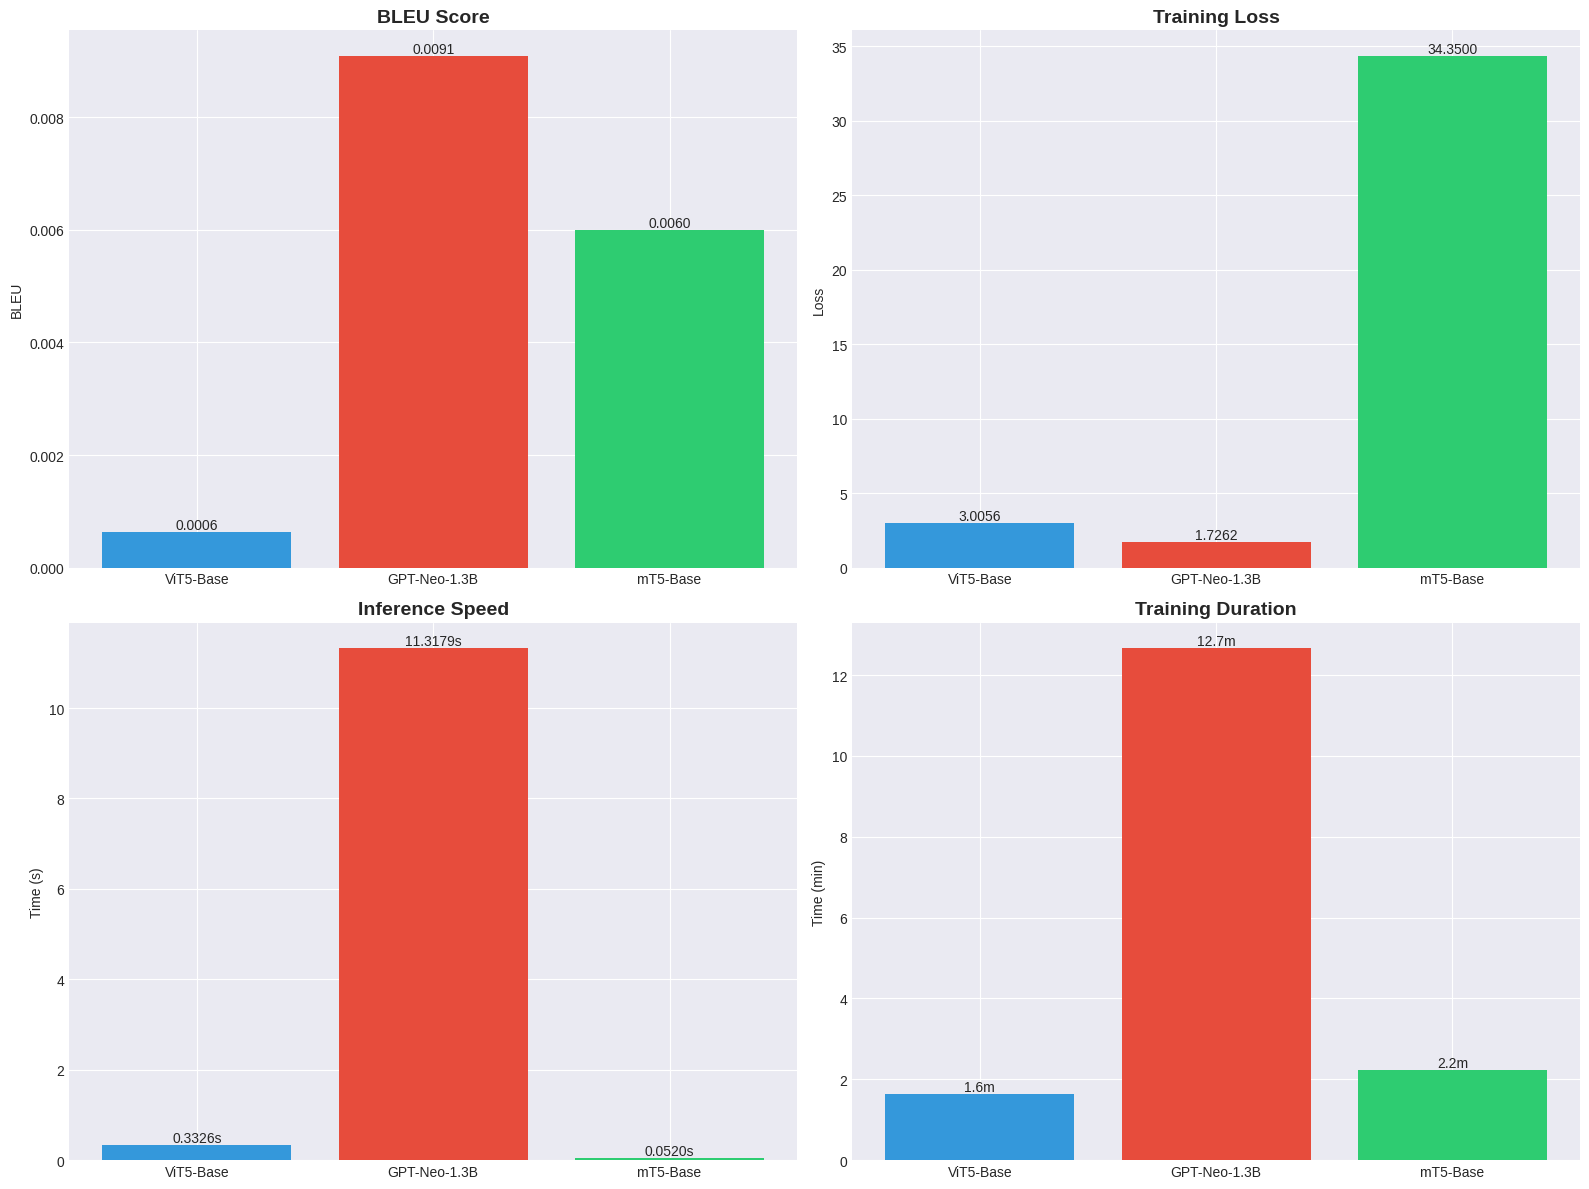


✅ Charts saved!

🎉 ALL DONE! Results in: /kaggle/working/models


In [9]:
# ========================================
# CELL 9: FINAL COMPARISON & VISUALIZATION
# ========================================

# Compile results
results_df = pd.DataFrame({
    "Model": ["ViT5-Base", "GPT-Neo-1.3B", "mT5-Base"],
    "Architecture": [
        "T5 Enc-Dec + Advanced",
        "GPT Decoder-Only",
        "mT5 Enc-Dec Vanilla"
    ],
    "Params": ["220M", "1.3B", "580M"],
    "Train Loss": [
        result1.metrics['train_loss'],
        result2.metrics['train_loss'],
        result3.metrics['train_loss']
    ],
    "BLEU Score": [
        metrics1['bleu'],
        metrics2['bleu'],
        metrics3['bleu']
    ],
    "Inference Time (s)": [
        metrics1['inference_time'],
        metrics2['inference_time'],
        metrics3['inference_time']
    ],
    "Training Time (min)": [
        result1.metrics['train_runtime'] / 60,
        result2.metrics['train_runtime'] / 60,
        result3.metrics['train_runtime'] / 60
    ]
})

print("\n" + "="*100)
print("🏆 FINAL COMPARISON - 3 DIFFERENT MODELS")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Save
results_df.to_csv(f"{config.OUTPUT_DIR}/comparison_results.csv", index=False)

# Best model
best_idx = results_df['BLEU Score'].idxmax()
print(f"\n🥇 BEST MODEL: {results_df.loc[best_idx, 'Model']}")
print(f"   Architecture: {results_df.loc[best_idx, 'Architecture']}")
print(f"   BLEU: {results_df.loc[best_idx, 'BLEU Score']:.4f}")

# Sample predictions
print("\n" + "="*100)
print("📝 SAMPLE PREDICTIONS")
print("="*100)

for i in range(min(5, len(metrics1['predictions']))):
    print(f"\n{'─'*100}")
    print(f"Example {i+1}")
    print(f"{'─'*100}")
    print(f"Reference:\n  {metrics1['references'][i]}")
    print(f"\nViT5-Base (Advanced):\n  {metrics1['predictions'][i]}")
    print(f"\nGPT-Neo (Decoder):\n  {metrics2['predictions'][i]}")
    print(f"\nmT5-Base (Vanilla):\n  {metrics3['predictions'][i]}")

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['#3498db', '#e74c3c', '#2ecc71']

# 1. BLEU
ax1 = axes[0, 0]
bars = ax1.bar(results_df['Model'], results_df['BLEU Score'], color=colors)
ax1.set_title('BLEU Score', fontsize=14, fontweight='bold')
ax1.set_ylabel('BLEU')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 2. Loss
ax2 = axes[0, 1]
bars = ax2.bar(results_df['Model'], results_df['Train Loss'], color=colors)
ax2.set_title('Training Loss', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 3. Inference Speed
ax3 = axes[1, 0]
bars = ax3.bar(results_df['Model'], results_df['Inference Time (s)'], color=colors)
ax3.set_title('Inference Speed', fontsize=14, fontweight='bold')
ax3.set_ylabel('Time (s)')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s', ha='center', va='bottom', fontsize=10)

# 4. Training Time
ax4 = axes[1, 1]
bars = ax4.bar(results_df['Model'], results_df['Training Time (min)'], color=colors)
ax4.set_title('Training Duration', fontsize=14, fontweight='bold')
ax4.set_ylabel('Time (min)')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}m', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{config.OUTPUT_DIR}/comparison_charts.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Charts saved!")
print(f"\n🎉 ALL DONE! Results in: {config.OUTPUT_DIR}")